<div style="float:left">
            <h1 style="width:450px">CASA0007 Practical 4: Advanced Regression</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

Welcome!

In this practical, we will learn different techniques of applying linear and logistic regression:

- Using VIF to deal with multicollinearity
- Building and interpreting a linear regression model
- Building and interpreting a logistic regression model

This week we will again be working with Python, using the packages of **pandas**, **scikit-learn**, and [**statsmodels**](https://www.statsmodels.org/stable/index.html). 

**statsmodel** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It provides a nice summary function for linear regression.

Let's first import the basic libraries we will need. **Run the script below to get started.**

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
import statsmodels
print(statsmodels.__version__)

0.13.2


# Data description and pre-processing

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C, along with weather and seasonal information. 

The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used here has been slightly processed by Christoph Molnar using [the R-script](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Github.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year, either 2011 or 2012.
- Number of days since the January 1st, 2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
  - **'GOOD'**: clear, few clouds, partly cloudy, cloudy
  - **'MISTY'**: mist + clouds, mist + broken clouds, mist + few clouds, mist
  - **'RAIN/SNOW/STORM'**: light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celcius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

We import the bicycle rental dataset as a Pandas dataframe (call it `bike_rental`). Then, we inspect the data, calculate summary statistics on all attributes, and generate simple plots of pairs of attributes.

In [3]:
bike_rental = pd.read_csv('https://github.com/huanfachen/QM_2023/raw/main/data/daily_count_rent_bike.csv')

In [4]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   yr               731 non-null    int64  
 3   mnth             731 non-null    object 
 4   holiday          731 non-null    object 
 5   weekday          731 non-null    object 
 6   workingday       731 non-null    object 
 7   weathersit       731 non-null    object 
 8   temp             731 non-null    float64
 9   hum              731 non-null    float64
 10  windspeed        731 non-null    float64
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [5]:
bike_rental.head()

,cnt,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In `bike_rental`, there are two data types
- Categorical (aka `object`)
- Numerical (including `int64` and `float64`)

Before undertaking regression, several steps should be done, which include:
- Converting categorical variables into dummy variables
- Dealing with multicollinearity (and removing some variables if necessary)

## Encoding of categorical variables
First, we need to convert categorical variables into **dummy variables** (or indicator variable), using `One-Hot Encoding`. For example, the `season` variable should be converted into four dummy variables after one-hot encoding (below is an example of five records):

|season||season_SPRING|season_SUMMER|season_AUTUMN|season_WINTER|
| ---- | --- | --- | --- | --- | --- |
|SPRING| ---> |1|0|0|0|
|SUMMER| ---> |0|1|0|0|
|SRPING| ---> |1|0|0|0|
|AUTUMN| ---> |0|0|1|0|
|WINTER| ---> |0|0|0|1|


We will use the ```get_dummies``` function for one-hot coding. The documentation of this function is [here](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [6]:
bike_rental_numeric = pd.get_dummies(bike_rental)

Then we check the variabbles after using ```get_dummies```. Each categorical variable has been replaced by **K** dummy variables, where K represents the number of categories in the original variable.

In [7]:
# check out the new dataFrame
bike_rental_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SPRING               731 non-null    uint8  
 8   season_SUMMER               731 non-null    uint8  
 9   season_WINTER               731 non-null    uint8  
 10  mnth_APR                    731 non-null    uint8  
 11  mnth_AUG                    731 non-null    uint8  
 12  mnth_DEZ                    731 non-null    uint8  
 13  mnth_FEB                    731 non

Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the **reference level**, and this level is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [8]:
bike_rental_final = bike_rental_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   yr                          731 non-null    int64  
 2   temp                        731 non-null    float64
 3   hum                         731 non-null    float64
 4   windspeed                   731 non-null    float64
 5   days_since_2011             731 non-null    int64  
 6   season_FALL                 731 non-null    uint8  
 7   season_SUMMER               731 non-null    uint8  
 8   season_WINTER               731 non-null    uint8  
 9   mnth_APR                    731 non-null    uint8  
 10  mnth_AUG                    731 non-null    uint8  
 11  mnth_DEZ                    731 non-null    uint8  
 12  mnth_FEB                    731 non-null    uint8  
 13  mnth_JUL                    731 non

## Checking the correlation between variables

Before modelling, we always want to know the correlation between variables before building models. We will use the ```dataframe.corr()``` function to generate the correlation matrix and plot it.

You can check the collinearity between attributes using a correlation matrix as below. Here is a question for you:

- **What can you say about this plot? For example, which pair of variables are highly correlated, and can you explain it?**

Text(0.5, 1.0, 'Correlation Matrix')

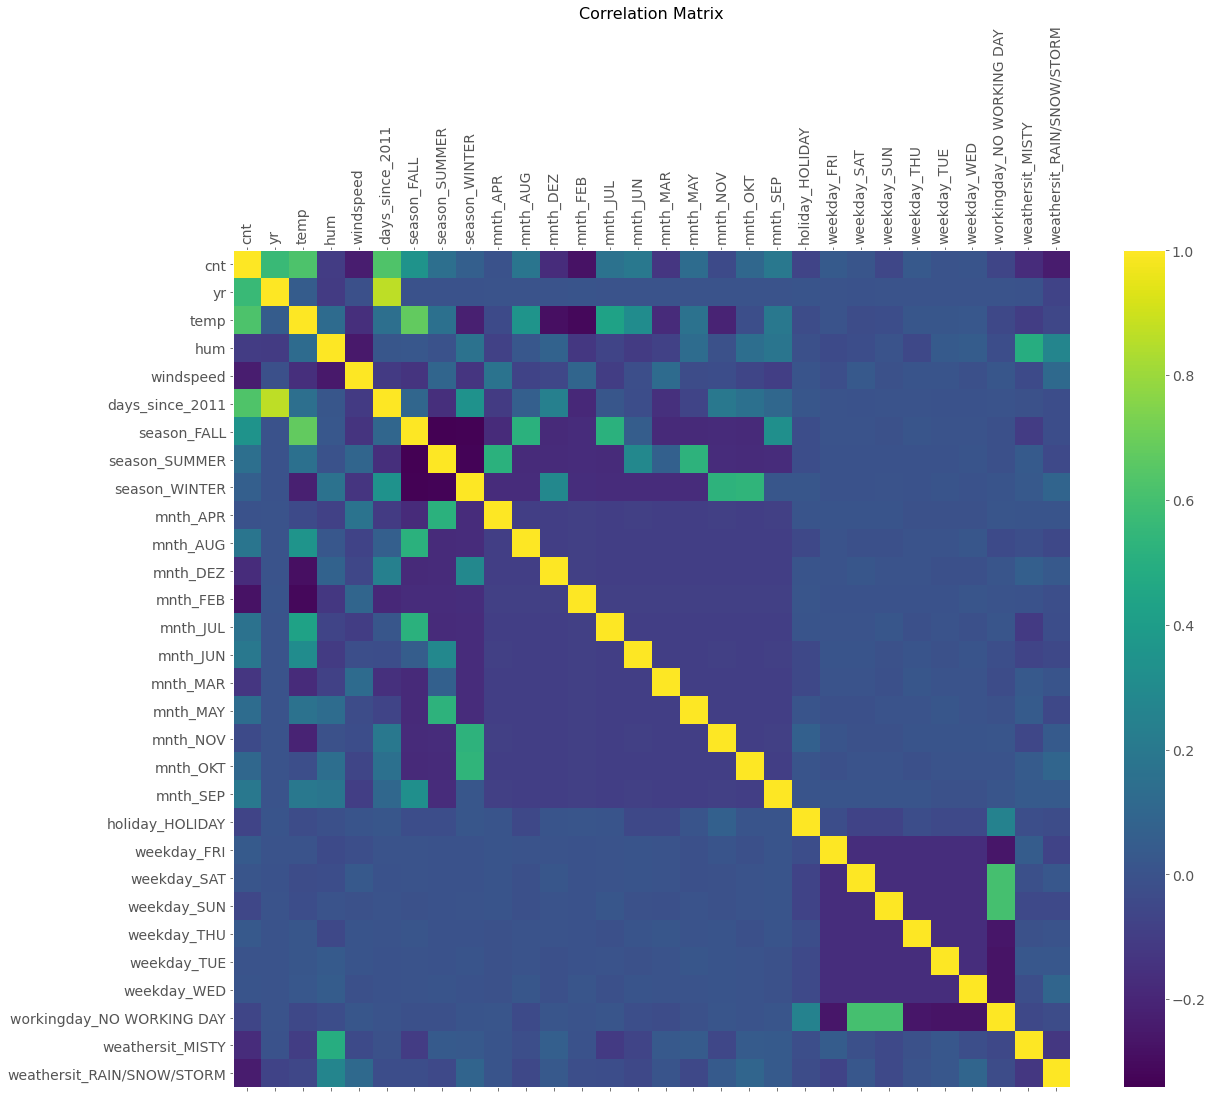

In [9]:
df = bike_rental_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# Predicting bike rental using seasons

Before we introduce VIF and build a comprehensive regression model, we will firstly develop a smaller model that predicts bike rental using only **season** variable. This example will demonstrate the consequence of multicollinearity.

One of the assumption underlying multiple regression is that **there is no multicollinearity** among the independent or explanatory variables. Informally, multicollinearity refers to the situation where one explanatory variable can be linearly predicted from others with a high level of accuracy. One example is that if we use all four season dummy variables for regression, there is multicolliearity between them. This is because:

`season_SPRING + season_SUMMER + season_FALL + season_WINTER = 1`

In other words, if we know the value of `seasons_SUMMER`, `season_FALL`, and `season_WINTER`, then we know the value of `season_SPRING`. One of these four variable is redundant.

What is the consequence of having multicollinearity between explanatory variables? We will demonstrate the consequence by building and comparing two regression models:

- Model 1: using four season; (an example of invalid regression)
- Model 2: using only three season variables, excluding 'season_SPRING';

In [10]:
# subset the data
bike_rental_seasons = bike_rental_numeric.loc[:,['cnt', 'season_SPRING', 'season_SUMMER', 'season_FALL', 'season_WINTER']]

## Model 1: using four seasons (problematic model）

Note that this is an example of PROBLEMATIC regression moddel, as it throws all season variables into the regression without variable selection (using VIF).

We find out that the output of the codes below varies across computers - at least two different results (see below). This proves that the result is unreliable, isn't it?

The lesson is: variable selection is an essential step before building regression models.

<img src="https://raw.githubusercontent.com/huanfachen/QM_2023/main/img/two_outputs_regression_four_seasons.png" alt="drawing" width="800"/>

In [11]:
# build the model, using this equation to formalute the regression model
# 'cnt ~ season_SPRING + season_SUMMER + season_FALL + season_WINTER'
# the left-hand side is the y variable and right-hand side is the x variables

model_cnt_seasons = sm.formula.ols('cnt ~ season_SPRING + season_SUMMER + season_FALL + season_WINTER', bike_rental_seasons).fit()
model_cnt_seasons.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           6.72e-67
Time:                        14:23:06   Log-Likelihood:                -6413.9
No. Observations:                 731   AIC:                         1.284e+04
Df Residuals:                     727   BIC:                         1.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3593.7860     46.425     77.411      0.000    3502.643    3684.929
season_SPRING  -989.6534    101.550     -9.746      0.000   -1189.019    -790.288
season_SUMMER  1398.5455    100.893     13.862      0.000    1200.470    1596.621
season_FALL    2050.5171    100.043     20.496      0.000    1854.109    2246.925
season_WINTER  1134.3769    102.224     11.097      0.000     933.687    1335.067
==============================================================================
Omnibus:                        3.050   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.765
Skew:                           0.080   Prob(JB):                        0.251
Kurtosis:                       2.745   Cond. No.                     1.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The condition number is calculated as 'ratio of largest to smallest eigenvalue of the exogeneous matrix' (which is a bit scary, but you don't need to understand this). 

Simply speaking, if you haven't selected the variables and you see a condition number greater than 1000, it indicates a strong multicollinearity between explanatory variables, and the model is NOT reliable or useful. In this case, please don't bother to interpret the model - simply re-select the variables and re-run the model.

[optional] This cell is **optional**.

We will use the regression model from the sklearn library to validate that this four-season model is unreliable.

The result shows that the coefficients of the four seasons are the same and very large. Again, it proves that the model is unreliable.

In [12]:
# reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

from sklearn import linear_model
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(bike_rental_seasons.loc[:,['season_SPRING', 'season_SUMMER', 'season_FALL', 'season_WINTER']], bike_rental_seasons.cnt)

# The coefficients
print("Coefficients: \n", regr.coef_)

Coefficients: 
 [-1.52476403e+16 -1.52476403e+16 -1.52476403e+16 -1.52476403e+16]


## Model 2 - Using three seasons

How about excluding `season_SPRING` and using only three season variabels for regression?

In [13]:
model_cnt_seasons_noSpring = sm.formula.ols('cnt ~ season_SUMMER + season_FALL + season_WINTER', bike_rental_seasons).fit()
model_cnt_seasons_noSpring.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           6.72e-67
Time:                        14:23:06   Log-Likelihood:                -6413.9
No. Observations:                 731   AIC:                         1.284e+04
Df Residuals:                     727   BIC:                         1.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2604.1326    116.598     22.334      0.000    2375.223    2833.042
season_SUMMER  2388.1989    164.221     14.543      0.000    2065.795    2710.603
season_FALL    3040.1706    163.352     18.611      0.000    2719.472    3360.869
season_WINTER  2124.0303    165.588     12.827      0.000    1798.943    2449.118
==============================================================================
Omnibus:                        3.050   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.765
Skew:                           0.080   Prob(JB):                        0.251
Kurtosis:                       2.745   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The **summary()** function gives a lot of information. Here we are interested in the following results:

- **R-squared**: 0.347.
- **Coefficients** of each variable
- **Cond. No.**: the condition number.

Some findings are:

- The R-squared value is the same as Model 1, which means that excluding `spring` does not lead to loss of information in the model.
- The Cond. No. is much smaller, which indicates that the multicollinearity issue in Model 1 has been resolved.

In this example, we have shown what multicolliearity is and we have tackled this issue by **mannually** excluding one variable. However, this approach is not applicable when there are a large number of explanatory variables, for which we need automatic approaches for resolving multicolliearity and selecting variables. That's why we introduce **VIF**.

As you can see, after one of the season variable ('spring') is excluded, the multicollinearity issue is tackled. The conditional number reduces to 4.81, and there is no more warning from `statsmodels`.

It is unlikely that you will get a different result on your computer.

# Using VIF to deal with multicollinearity

Here we introduce VIF to automatically deal with multicollinearity.

The `Variance Inflation Factor` (VIF) is a measure of multicollinearity among predictors within a multiple regression task. It is the quotient of the variance in a model with multiple predictors by the variance of a model with a single predictor. More explanation of the theory can be found [here](https://online.stat.psu.edu/stat501/lesson/12/12.4). 

Using VIF to deal with multicollineartiy consists of the following steps:

1. Initialise ```L``` as the list of explanatory variables. (*HINT*: the response variable is not needed for calculating VIF)
2. Calculate the VIF for each variable in ```L``` using the other variables. (*HINT*: the order of computing VIF is irrelevant).
3. If the highest VIF is larger than the threshold, remove the variable from the list ```L```. (*HINT*: each time, no more than one variable is removed from ```L```. This is because removing any variable will affect the VIF of the other variables.)
4. Repeat Step 2-3, until no VIF is larger than the threshold.
5. Return ```L```.

Below is an example of using VIF on the `bike_rental` dataset. Note that the `statsmodels` package is used.

In [14]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

You are not required to understand every detail of the ```drop_column_using_vif_``` function. Rather, the key point is to understand its inputs and outputs, and how to use it for your datasets. 

As an example, we will use the `drop_column_using_vif_` function on `bike_rental_seasons`. As shown below, one of the season variable would be dropped, and the dataframe returned contains only three variables.

In [15]:
bike_rental_seasons_new = drop_column_using_vif_(bike_rental_seasons.drop('cnt', axis=1))

Dropping: season_SPRING


/opt/conda/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


*Hint*: You can ignore the warnings of `RuntimeWarning: divide by zero encountered in double_scalars`.

Someone may ask - given that VIF will drop one (or multiple) season variables, there is no need to drop one season category during one-hot encoding. This is not true. As we know there is multicollinearity between the four season variables, a good practice is to drop one of them during one-hot encoding. Moreover, by manually dropping one category, we can select which category to drop, depending on our preference and domain knowledge. The dropped category is called reference level and is quite important for interpreting the result.

We have learnt one-hot encoding of categorical variables and VIF for variable selection. Now, we can build a comprehensive model for bike rental using all variables.

# Building and interpreting a linear regression model

## Building the model

We are going to use VIF on the whole dataset, build a linear model, and interpret the result.

First, check out the columns. Remember that we have conducted one-hot encoding for categorical variables and dropped one of the categories.

In [16]:
bike_rental_final.columns

Index(['cnt', 'yr', 'temp', 'hum', 'windspeed', 'days_since_2011',
       'season_FALL', 'season_SUMMER', 'season_WINTER', 'mnth_APR', 'mnth_AUG',
       'mnth_DEZ', 'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY',
       'mnth_NOV', 'mnth_OKT', 'mnth_SEP', 'holiday_HOLIDAY', 'weekday_FRI',
       'weekday_SAT', 'weekday_SUN', 'weekday_THU', 'weekday_TUE',
       'weekday_WED', 'workingday_NO WORKING DAY', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

Second, we use VIF on the **bike_rental_final** dataset.

In [17]:
# using VIF on the bike_rental dataset
df_predictors_selected_VIF = drop_column_using_vif_(bike_rental_final.drop('cnt', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: holiday_HOLIDAY
Dropping: days_since_2011
Dropping: season_FALL
Dropping: workingday_NO WORKING DAY
Dropping: temp
Dropping: season_WINTER
Dropping: season_SUMMER
The columns remaining after VIF selection are:
Index(['yr', 'hum', 'windspeed', 'mnth_APR', 'mnth_AUG', 'mnth_DEZ',
       'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR', 'mnth_MAY', 'mnth_NOV',
       'mnth_OKT', 'mnth_SEP', 'weekday_FRI', 'weekday_SAT', 'weekday_SUN',
       'weekday_THU', 'weekday_TUE', 'weekday_WED', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')


Now we can fit a linear regression model after dealing with the multicollinearity. There are at least two different ways to forumlate a linear regression model using `statsmodels`.

1. Using `statsmodels.api.formula.ols`. A specific formula is needed.
2. Using `statsmodels.api.OLS`. You don't need to write the formula. Assign the `y` and `X` in the linear regression to the `endog` and `exog` parameters, respectively. 

Now we use the `statsmodels.api.OLS` to build and fit a linear regression model.

In [18]:
model_bike_rental = sm.OLS(endog=bike_rental_final[['cnt']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_bike_rental.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     127.4
Date:                Mon, 30 Oct 2023   Prob (F-statistic):          6.62e-229
Time:                        14:23:09   Log-Likelihood:                -5984.4
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     708   BIC:                         1.212e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.257e+06   1.33e+05    -32.053      0.000   -4.52e+06      -4e+06
yr                          2117.7896     66.007     32.084      0.000    1988.196    2247.383
hum                           -6.0929      3.232     -1.885      0.060     -12.439       0.253
windspeed                    -45.9479      6.916     -6.643      0.000     -59.527     -32.369
mnth_APR                    2403.4612    160.553     14.970      0.000    2088.245    2718.677
mnth_AUG                    3310.1188    160.566     20.615      0.000    2994.877    3625.361
mnth_DEZ                    1274.8808    160.371      7.950      0.000     960.022    1589.740
mnth_FEB                     431.7215    162.233      2.661      0.008     113.207     750.236
mnth_JUL                    3126.1974    160.830     19.438      0.000    2810.437    3441.958
mnth_JUN                    3371.6346    160.772     20.971      0.000    3055.987    3687.283
mnth_MAR                    1579.6491    158.912      9.940      0.000    1267.653    1891.645
mnth_MAY                    3126.1887    162.023     19.295      0.000    2808.086    3444.292
mnth_NOV                    1995.8622    161.375     12.368      0.000    1679.031    2312.693
mnth_OKT                    3141.8429    161.719     19.428      0.000    2824.337    3459.349
mnth_SEP                    3614.9656    164.581     21.965      0.000    3291.841    3938.090
weekday_FRI                  284.2976    122.643      2.318      0.021      43.509     525.086
weekday_SAT                  262.7645    122.135      2.151      0.032      22.974     502.555
weekday_SUN                 -187.6888    122.035     -1.538      0.124    -427.283      51.905
weekday_THU                  306.3686    122.605      2.499      0.013      65.655     547.082
weekday_TUE                  220.1168    122.306      1.800      0.072     -20.008     460.242
weekday_WED                  274.9238    122.679      2.241      0.025      34.067     515.781
weathersit_MISTY            -620.0241     86.766     -7.146      0.000    -790.374    -449.674
weathersit_RAIN/SNOW/STORM -2269.0044    223.268    -10.163      0.000   -2707.350   -1830.658
==============================================================================
Omnibus:                      128.767   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.189
Skew:                          -0.848   Prob(JB):                     5.64e-87
Kurtosis:                       6.188   Cond. No.                     8.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.18

## An extra note on condition number

In the model above, even if we have tackled the multicollinearity between variables, there is still a warning about the large condition number. Condition number does not always indicate strong multicollinearity. There are two potential reasons for a large condition number:

- Strong multicollinearity between x variables.
- Different scales of variables.

**Therefore, if you have used VIF to tackle the multicollinearity between x variables and select variables, you can ignore the warning about a large condition number.**

## Residual analysis

We can conduct residual analysis using 'Residual vs. Fitted plot'. **Can you review the following conditions using the residuals vs. fitted plot and the residual histogram plot?** 

- Linear relationship
- Independent errors
- Normally distributed errors
- Equal variance

Additionally, it is important to discuss the potential outliers of this model.

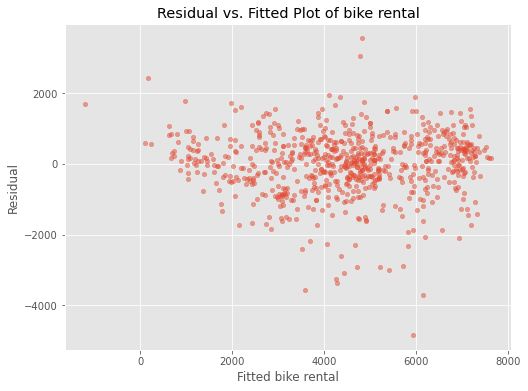

In [19]:
# Residuals vs. Fitted plot

# Set the figure size
plt.figure(figsize=(8, 6))  
# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5, s=20)
# plt.scatter(model_bike_rental.fittedvalues, model_bike_rental.resid, alpha = 0.5)
# adding title and labels
plt.xlabel('Fitted bike rental')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of bike rental')
# Adding grid lines
plt.grid(True)
plt.show()

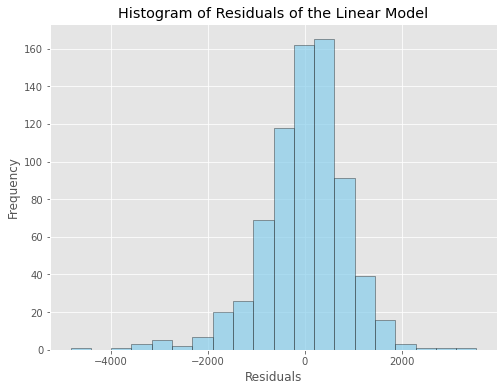

In [20]:
# Histogram of residuals

# Set the figure size
plt.figure(figsize=(8, 6))  

# Plotting the histogram
plt.hist(model_bike_rental.resid, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals of the Linear Model')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

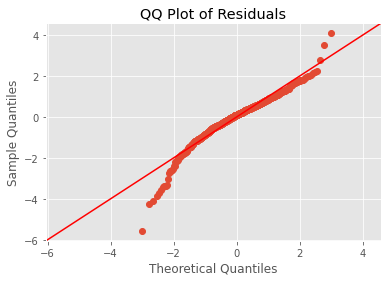

In [21]:
# (optional) the QQ plot of residuals
# More details: https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
fig = sm.qqplot(model_bike_rental.resid, fit=True, line="45")
plt.title('QQ Plot of Residuals')

# Adding grid lines (optional)
plt.grid(True)

# Display the plot
plt.show()

## Discussion of the four conditions

- Linear relationship

The points in the residual plot do not bounce randomly around the x axis (residual=0). Therefore, it looks like ther is no linear relationship between the variables.

- Independent errors

The points in the residual plot are not randomly distributed and some clusters/patterns can be seens. Therefore, it is unlikely that the errors are independently distributed.

- Normally distributed errors

The histogram is asymmetric ans shows a positive skew, with more data points clustered to the right of residual=0.

The QQ plot shows that the residuals deviates from the theoretical quantiles when the residual value is very small or large.

Therefore, it is not likely that the residuals are normally distributed.

- Equal variance

The points do not form a horizontal band around residual=0, and the range of residuals increases with the fitted y value. Therefore, it is unlikely that the residuals have equal variance.

## Statistical tests of the four conditions (OPTIONAL)

### Linear relationship

We will use the Rainbow test for testing the linear relationship. Details can be found [in this link](https://www.statsmodels.org/v0.13.5/generated/statsmodels.stats.diagnostic.linear_rainbow.html).

This test assumes residuals are homoskedastic (the null hypothesis) and may reject a correct linear specification if the residuals are heteroskedastic and the p value is less than or equal to the predefined significance level (usually 0.05).

In [22]:
test_rainbow = statsmodels.stats.diagnostic.linear_rainbow(model_bike_rental)
# This function returns a tuple consisting of two values: the test statistic based on the F test and the pvalue of the test
# Note that these two values are not named. Therefore, you need to know the order before accessing these two values.
print("The p value of the rainbow test: {:.4f}".format(test_rainbow[1]))

The p value of the rainbow test: 0.0039


As the p value is less than 0.05, we will reject the null hypothesis. This dataset and model does not meet the linear relationship condition.

### Independent errors

We will use the Durbin-Watson test and and Ljung-Box test for testing the independent errors. 

The details of Durbin-Watson test can be found [in this link](https://www.statsmodels.org/v0.13.5/generated/statsmodels.stats.stattools.durbin_watson.html).

This test assumes that there is no serial correlation in the residuals. 

This statistic will always be between 0 and 4. 

If there is no serial correlation, the test statistic equals 2. 

The closer to 0, the more evidence for positive serial correlation. 

The closer to 4, the more evidence for negative serial correlation. 

Empirically, if the test statistic is between 1 and 2, it is likely that there is no serial correlation in the residuals.

Unfortunately, the statsmodels library does not provide the p value of the Durbin-Watson test.

The result below shows that this model has a Durbin Watson test statistic of 1.06, which demonstrates that there might be serial correlation in this model and the residuals are not independently distributed.

In [23]:
test_dw = statsmodels.stats.stattools.durbin_watson(model_bike_rental.resid)
print("Durbin-Watson test statistic is: {:.4f}".format(test_dw))

Durbin-Watson test statistic is: 1.0579


Alternatively, we can use the Ljung-Box test for testing for serial correlation in the linear model. The p value of this test is available.

Details of this test is [here](https://www.statsmodels.org/v0.13.5/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html).

This test returns a dataframe with two columns, including the Ljung-Box test statistic and the p-value of this statistic based on the chi-square distribution.

The Ljung-Box test requires a parameter of *lag*, which specifies the range of autocorrelation being tested.

Each row of this dataframe represents a *lag* in this test. By default, the range of the lag is [1,10].

In [24]:
test_Ljung_Box = statsmodels.stats.diagnostic.acorr_ljungbox(model_bike_rental.resid)
# print the result
print(test_Ljung_Box)
print("The maximum p value of the Ljung Box test: {:.4f}".format(test_Ljung_Box.lb_pvalue.max()))

                                    lb_stat  \
1                                  161.5621   
2                                  222.9460   
3                                  240.5117   
4                                  250.8307   
5                                  266.7736   
6                                  289.2303   
7                                  300.8728   
8                                  307.7524   
9                                  310.3178   
10                                 310.3741   

                                  lb_pvalue  
1                                    0.0000  
2                                    0.0000  
3                                    0.0000  
4                                    0.0000  
5                                    0.0000  
6                                    0.0000  
7                                    0.0000  
8                                    0.0000  
9                                    0.0000  
10                    

As all p values of this test is less than the significance level of 0.05, we will reject the hypothesis and conlude that the residuals are not independent.

### Normally distributed errors

We will use the Jarque-Bera test for testing the normality of residuals. 

The details of Jarque-Bera test can be found in [this link](https://www.statsmodels.org/v0.13.5/generated/statsmodels.stats.stattools.jarque_bera.html).

The null hypothesis of this test is that the data is normally distributed.

This test will return a tuple of four values, namely the Jarque-Bera test statistic, p value of the test statistic, estimated skewness of the data, and estimated kurtosis of the data.

In [25]:
test_JB = statsmodels.stats.stattools.jarque_bera(model_bike_rental.resid)
print("The p value of the Jarque Bera test: {:.4f}".format(test_JB[1]))

The p value of the Jarque Bera test: 0.0000


As the p value is less than 0.05, we will reject the null hypothesis and conclude that the residuals are not normally distributed.

### Equal variance

We will use the Goldfeld-Quandt homoskedasticity test here to determine if heteroscedasticity is present in a regression model.

The details of this test can be found in [this link](https://www.statsmodels.org/v0.13.5/generated/statsmodels.stats.diagnostic.het_goldfeldquandt.html).

Note that the usage and parameters of this test are different from the above tests. This test contains two essential input data:

- y: the dependent variable (or endogenous variable)
- x: the independent variables (or regressors, or exogenous variable)

The null hypothesis is that is that the variance in the two sub-samples are the same. The alternative hypothesis can be increasing (i.e. the variance in the second samples is larger than in the first), or decreasing or two-sided.

This test will return a tuple of four values, namely the Jarque-Bera test statistic, p value of the test statistic, estimated skewness of the data, and estimated kurtosis of the data.

Input of this test:

To get the value of y and x, we can use either the *y=bike_rental_final[['cnt']]* and *x=sm.add_constant(df_predictors_selected_VIF)*, or the information stored in the regression model model_bike_rental. 

This model object contains a lot of information, including the input data and the model result.

Output of this test:
This test will return a tuple of at least three values, namely the test statistic, p value of the test statistic, and the ordering used in the alternative.


In [26]:
statsmodels.stats.diagnostic.het_goldfeldquandt(model_bike_rental.model.endog, model_bike_rental.model.exog)

(2.4455741141646694, 1.8062460007874003e-16, 'increasing')

As the p value is less than 0.05, we will reject the null hypothesis and conclude that the residuals do not have equal variance.

## Interpreting the model

The R-squared value is 0.798, meaning that 79.8% of the total variance of the bike rental can be explained by the variables used in the model.

**Can you interpret the coefficients for the windspeed and the season variables, using what we have learned from the lecture?**

# Building a logistic regression model

The bike rental company is interested to predict whether the daily rental would exceed 4,500. 

This is a classification problem, in which the outcome variable is a binary value - True or False. For this purpose, we will build a logistic regression model.

We will use the function of `scikit-learn` package to build this model.

**Can you explain this predictive accraucy of this model?**

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------------------
Print the model:
yr : 0.001232209198998381
hum : -0.02934536231170154
windspeed : -0.07224766273680963
mnth_APR : 0.21939495024227193
mnth_AUG : 1.44893565515912
mnth_DEZ : -0.8564881154320368
mnth_FEB : -2.3301414997239975
mnth_JUL : 1.0377054188379287
mnth_JUN : 1.9237419386146972
mnth_MAR : -0.30149130162376536
mnth_MAY : 1.2813950751088834
mnth_NOV : -0.3568126406945068
mnth_OKT : 0.9718226149890092
mnth_SEP : 1.6141679713677874
weekday_FRI : 0.1297656352833994
weekday_SAT : 0.13247915546795785
weekday_SUN : -0.218416821949784
weekday_THU : 0.19171306117902986
weekday_TUE : 0.2598676875574429
weekday_WED : 0.22869883016067893
weathersit_MISTY : -0.5659503576722563
weathersit_RAIN/SNOW/STORM : -0.8886263175168905
------------------------------------------
Accuracy of the model is: 0.7551299589603283
The confusion matrix is:


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

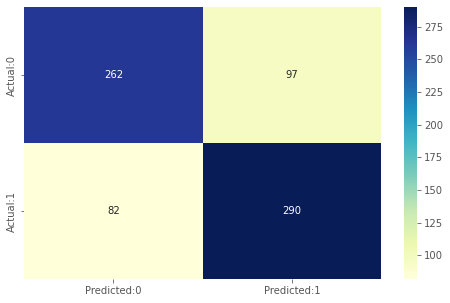

In [27]:
# If daily rental is larger than 4500, it is of Class 'True'. Otherwise, it is in Class 'False'.
threshold_bike_rental = 4500

X = df_predictors_selected_VIF
y = bike_rental_final[['cnt']] > threshold_bike_rental
###################

logreg = LogisticRegression()
logreg.fit(X, y)
y_pred=logreg.predict(X)

# print the coefficient in the model
print("------------------------------------------")
print("Print the model:")
coef_dict = {}
for coef, feat in zip(logreg.coef_.flatten().tolist(),X.columns):
    coef_dict[feat] = coef
    print(feat, ":", coef)
print("------------------------------------------")
    
acc = sklearn.metrics.accuracy_score(y,y_pred)
print("Accuracy of the model is: " + str(acc))

# Another evaluation: confusion matrix
print("The confusion matrix is:")
cm=confusion_matrix(y,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

The accuracy of this classification is 0.743, meaning that the model can correctly predict 74.3% of the daily bicycle rental regarding whether it is larger than 4500.

The confustion matrix shows the number of occurrences in the four combinations between actual and predicted types. For example, there are 289 samples that are correctly predicted as Type 1 (i.e. daily rental over 4,500).

## Conclusions

1. It is necessary to select variables (e.g. VIF) before building regression models.
1. The four conditions of linear regression can be diagnosed via residual plots or statistical tests.
1. It is important to interpret the linear regression model based on the R Squared and coefficients.

## Credits
### Contributors:
The following individuals have contributed to these teaching materials: Huanfa Chen (huanfa.chen@ucl.ac.uk)

### License
These teaching materials are licensed under a mix of The MIT License and the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license.

### Acknowledgements
This dataset and some analysis is from Chapter 5 of [this online book](https://christophm.github.io/interpretable-ml-book/limo.html#interpretation) written by [Christoph Molnar](https://christophmolnar.com/).

### Dependencies
This notebook depends on the following libraries: pandas, matplotlib, statsmodels, sklearn